# African Nations and Ruggedness

Example from Statistical Rethinking chapter 7. Code adapted from "Statistical Rethinking with Python and PyMC3" at https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3; code by contributors to that repository and Dylan Murphy.

In this example, we examine the effect of terrain ruggedness on economy on different continents.

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Load the data

In [2]:
d = pd.read_csv('data/rugged.csv', sep=';', header=0)
#d.head()

# make log version of outcome
d.log_gdp = np.log(d.rgdppc_2000)

# extract countries with GDP data
dd = d[np.isfinite(d['rgdppc_2000'])]

# split countries into Africa and non-Africa
d.A1 = dd[dd.cont_africa==1]  # Africa
d.A0 = dd[dd.cont_africa==0]  # not Africa

<ipython-input-2-e2b59413328d>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.log_gdp = np.log(d.rgdppc_2000)
<ipython-input-2-e2b59413328d>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.A1 = dd[dd.cont_africa==1]  # Africa
<ipython-input-2-e2b59413328d>:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.A0 = dd[dd.cont_africa==0]  # not Africa


#### Fitting two separate regression models

Here, we fit separate regression models for African and non-African nations. 

In [3]:
# Fit the regression models with this code.
# African nations
with pm.Model() as model_7_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.HalfCauchy('sigma', 5)
    mu = pm.Deterministic('mu', a + bR * d.A1['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(d.A1['rgdppc_2000']))
    trace_7_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1729.72draws/s]


/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

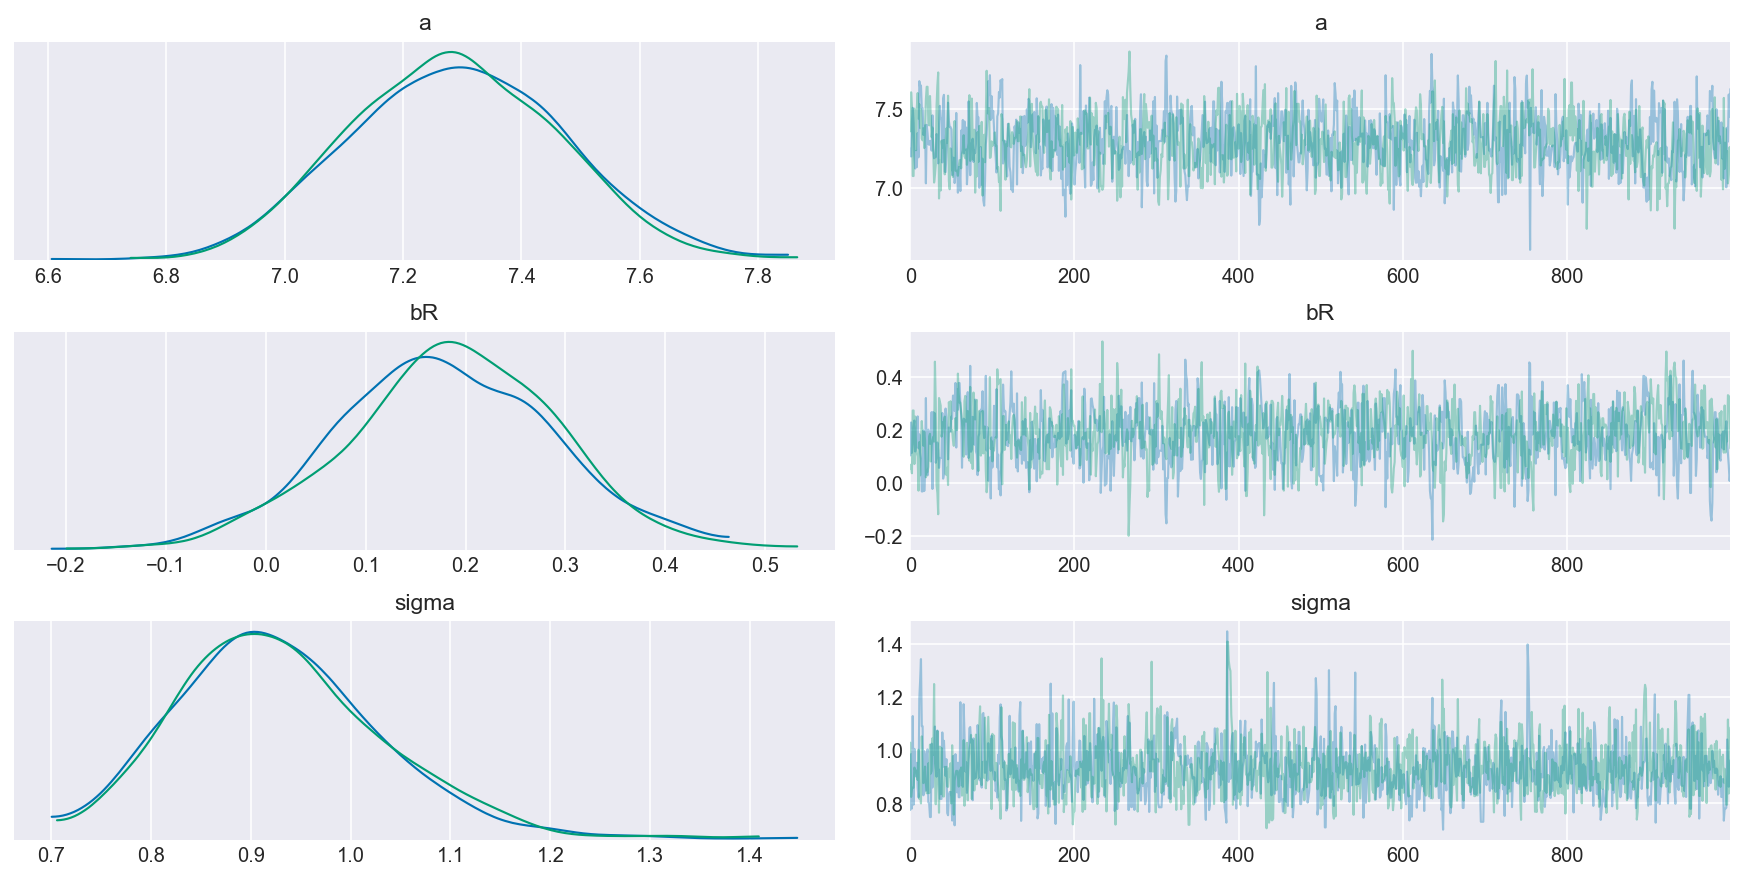

In [4]:
varnames = ['a', 'bR', 'sigma']
pm.traceplot(trace_7_2, varnames);

In [5]:
# non-African nations
with pm.Model() as model_7_2_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.HalfCauchy('sigma', 5)
    mu = pm.Deterministic('mu', a + bR * d.A0['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(d.A0['rgdppc_2000']))
    trace_7_2_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1581.20draws/s]


/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

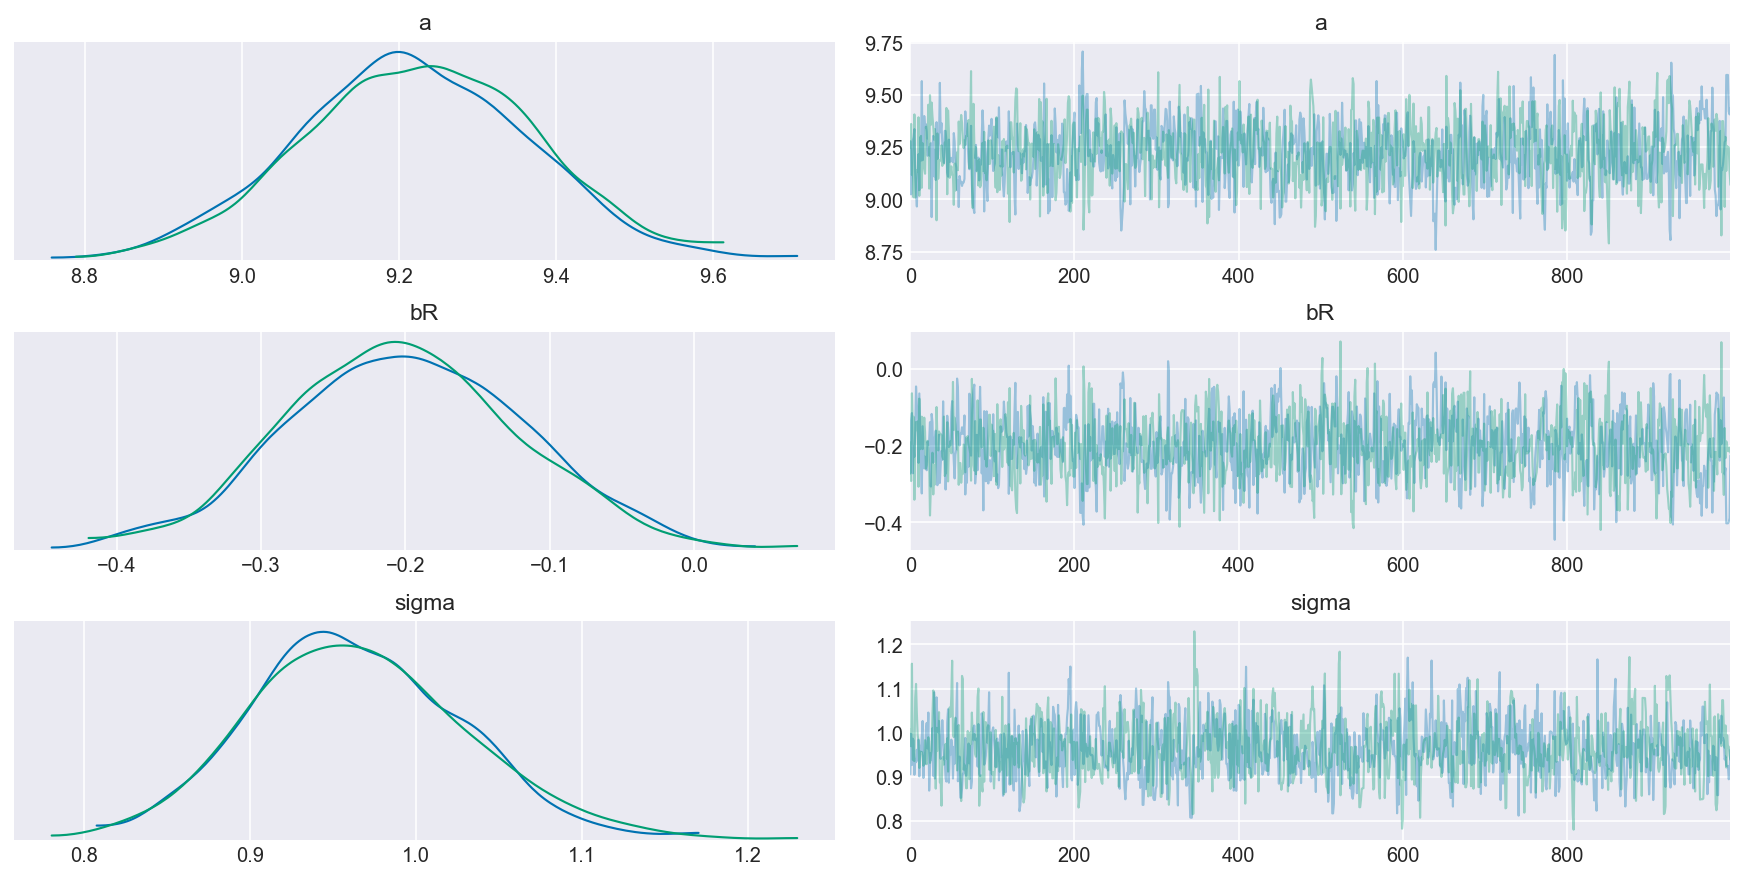

In [6]:
pm.traceplot(trace_7_2_2, varnames);

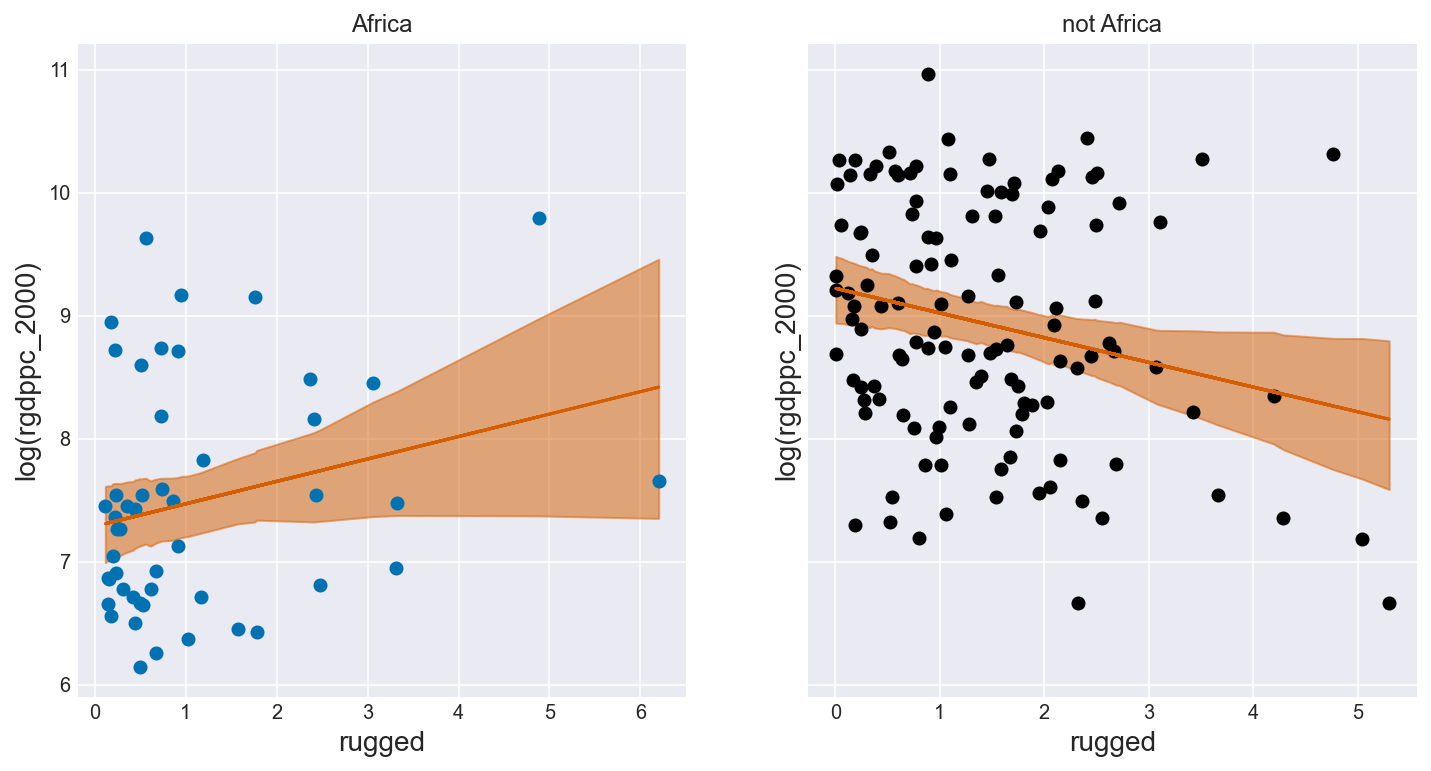

In [7]:
# Plot the data

mu_mean = trace_7_2['mu']
mu_hpd = pm.hpd(mu_mean)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'C0o')
ax1.plot(d.A1['rugged'], mu_mean.mean(0), 'C2')
idx = np.argsort(d.A1['rugged'])
# I used .sort_values() as it does a better job at sorting them as opposed to indexing a sorted list.
ax1.fill_between(d.A1['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.5)
ax1.set_title('Africa')
ax1.set_ylabel('log(rgdppc_2000)', fontsize=14);
ax1.set_xlabel('rugged', fontsize=14)

mu_mean = trace_7_2_2['mu']
mu_hpd = pm.hpd(mu_mean)

ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(d.A0['rugged'], mu_mean.mean(0), 'C2')
ax2.set_title('not Africa')
ax2.set_ylabel('log(rgdppc_2000)', fontsize=14)
ax2.set_xlabel('rugged', fontsize=14)
idx = np.argsort(d.A0['rugged'])
ax2.fill_between(d.A0['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.5);


#### A pooled regression

In [8]:
# Model the entire data
with pm.Model() as model_7_3:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1487.60draws/s]


#### A pooled regression, but with a dummy variable for Africa

Here, we attempt to do a little better by including a dummy variable for Africa. As we'll see, this isn't really enough -- because it doesn't allow the slopes to vary.

In [9]:
# Model the entire data including a dummy variable
with pm.Model() as model_7_4:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1326.14draws/s]


#### Plotting the regressions

In [10]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_4['bR'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_4['bR'])))

for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_4['a'] + trace_7_4['bR'] * rugged_seq[iSeq] + trace_7_4['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_4['a'] + trace_7_4['bR'] * rugged_seq[iSeq] + trace_7_4['bA'] * 1 

In [11]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T)

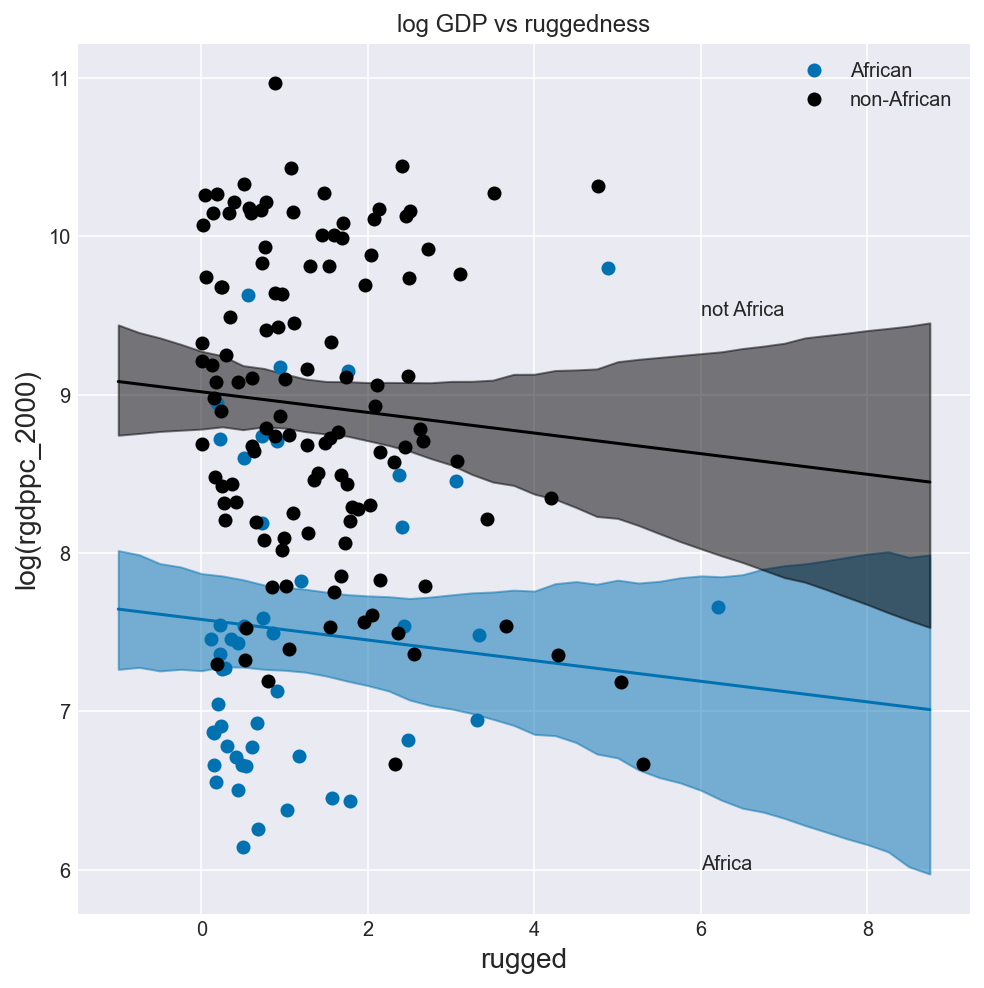

In [12]:
plt.figure(figsize=(8,8))
plt.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'C0o', label = 'African')
plt.plot(rugged_seq, mu_mean_Africa, 'C0')
plt.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='C0', alpha=0.5)
plt.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko', label = 'non-African')
plt.plot(rugged_seq, mu_mean_NotAfrica, 'k')
plt.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
plt.annotate('not Africa', xy=(6, 9.5))
plt.annotate('Africa', xy=(6, 6))
plt.ylabel('log(rgdppc_2000)', fontsize=14)
plt.xlabel('rugged', fontsize=14)
plt.title('log GDP vs ruggedness')
plt.legend();

#### Two approaches to modeling interactions

We can model the interactions directly, by including a product term in the model equation, or by indexing two separate slopes and fitting them using a multilevel model.

In [13]:
with pm.Model() as model_7_5:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.HalfCauchy('sigma', 5)
    gamma = bR + bAR * dd.cont_africa
    mu = pm.Deterministic('mu', a + gamma * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1130.05draws/s]


In [14]:
pm.summary(trace_7_5, var_names = ['a', 'bR', 'bA', 'bAR'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,9.180,0.138,8.928,9.448,0.004,0.003,1057.0,1054.0,1053.0,1185.0,1.0
bR,-0.180,0.076,-0.321,-0.037,0.002,0.002,1109.0,1058.0,1113.0,1317.0,1.0
bA,-1.839,0.219,-2.249,-1.448,0.007,0.005,1042.0,1032.0,1049.0,1142.0,1.0
bAR,0.342,0.126,0.118,0.578,0.004,0.003,1123.0,1123.0,1124.0,1279.0,1.0


In [15]:
with pm.Model() as mlmodel:
    a = pm.Normal('a', mu=8, sd=100)
    tau = pm.HalfCauchy('tau', 5)
    bRA = pm.Normal('bRA', mu=0, sd=tau)
    bRNA = pm.Normal('bRNA', mu=0, sd=tau)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.HalfCauchy('sigma', 5)
    #gamma = bR + bAR * dd.cont_africa
    mu = pm.Deterministic('mu', a + bRNA * dd.rugged * (1-dd.cont_africa) + bRA * dd.rugged * dd.cont_africa + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_ml = pm.sample(1000, target_accept = 0.95, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, bRNA, bRA, tau, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 746.03draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [16]:
pm.summary(trace_ml, var_names = ['a', 'bA', 'bRNA', 'bRA'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,9.148,0.145,8.882,9.413,0.006,0.005,507.0,507.0,511.0,785.0,1.00
bA,-1.785,0.235,-2.230,-1.383,0.010,0.007,544.0,544.0,550.0,797.0,1.00
bRNA,-0.160,0.081,-0.316,-0.015,0.004,0.003,514.0,514.0,513.0,971.0,1.01
bRA,0.137,0.104,-0.052,0.328,0.004,0.003,828.0,828.0,828.0,1145.0,1.00


#### Model comparison

In [17]:
comp_df = pm.compare({'simple':trace_7_3, 'dummy':trace_7_4, 'interactions':trace_7_5, 'multilevel':trace_ml}, ic='loo', scale='log')
comp_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
interactions,0,-234.508,4.87324,0,0.571474,7.06522,0,False,log
multilevel,1,-235.02,5.16953,0.511886,0.338665,6.20548,0.387708,False,log
dummy,2,-238.331,4.48217,3.82274,0.0898609,6.96979,2.97249,False,log
simple,3,-269.736,2.58073,35.2283,5.0105e-07,7.0308,7.28916,False,log


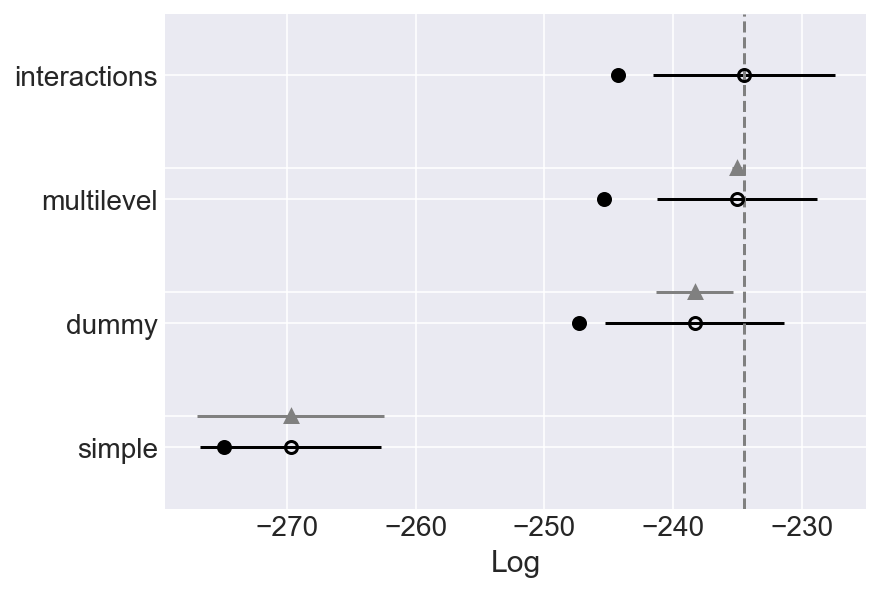

In [18]:
pm.compareplot(comp_df);

#### The interaction model, rewritten

In [19]:
with pm.Model() as model_7_5b:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR*dd.rugged + bAR*dd.rugged*dd.cont_africa + bA*dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1131.95draws/s]


#### Visualizing the regressions
First calculate the necessary posterior predicted means. The link function is replaced by a loop. We'll use model 7.5b since it's a one-liner.

In [20]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_5b['bR'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_5b['bR'])))
for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*0 +\
                              trace_7_5b['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*1 +\
                              trace_7_5b['bA'] * 1

In [21]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T)

#### Visualizing the multilevel models

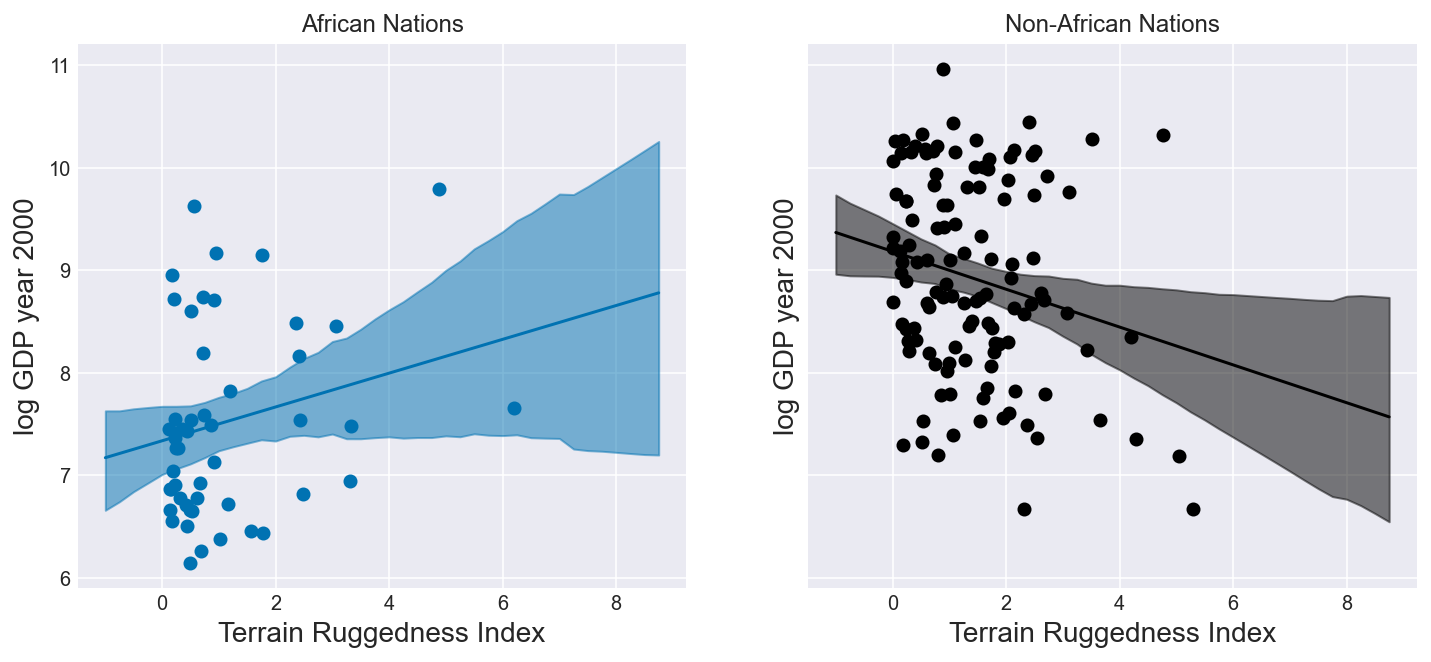

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'C0o')
ax1.plot(rugged_seq, mu_mean_Africa, 'C0')
ax1.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='C0', alpha=0.5)
ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)
               
ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(rugged_seq, mu_mean_NotAfrica, 'k')
ax2.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14);

In [23]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_ml['bRNA'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_ml['bRA'])))
for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_ml['a'] + trace_ml['bRNA']*rugged_seq[iSeq]
                              
    mu_pred_Africa[iSeq] = trace_ml['a'] + trace_ml['bRA']*rugged_seq[iSeq] + \
                              trace_ml['bA'] * 1
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T)

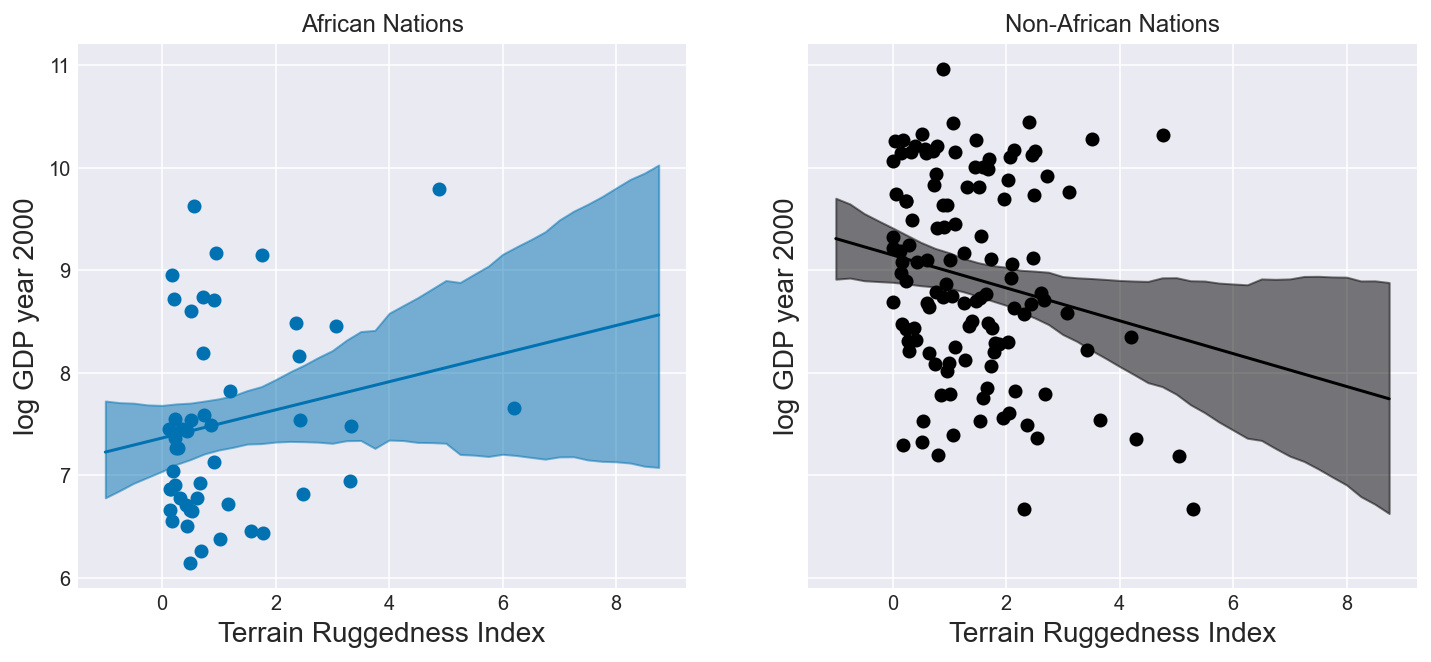

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'C0o')
ax1.plot(rugged_seq, mu_mean_Africa, 'C0')
ax1.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='C0', alpha=0.5)
ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)
               
ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(rugged_seq, mu_mean_NotAfrica, 'k')
ax2.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14);

## Some more examination

#### Code 7.12

In [25]:
varnames = ['a', 'bA', 'bR', 'bAR', 'sigma']
pm.summary(trace_7_5b, varnames).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,9.183,0.140,8.930,9.455,0.005,0.003,956.0,955.0,957.0,978.0,1.0
bA,-1.847,0.223,-2.284,-1.473,0.007,0.005,999.0,997.0,998.0,1301.0,1.0
bR,-0.184,0.079,-0.318,-0.025,0.003,0.002,981.0,952.0,981.0,1110.0,1.0
bAR,0.349,0.129,0.118,0.594,0.004,0.003,968.0,923.0,975.0,1224.0,1.0
sigma,0.954,0.057,0.851,1.063,0.001,0.001,1462.0,1446.0,1484.0,1173.0,1.0


#### Code 7.13

In [26]:
gamma_Africa = trace_7_5b['bR'] + trace_7_5b['bAR'] * 1
gamma_notAfrica = trace_7_5b['bR']

#### Code 7.14

In [27]:
print("Gamma within Africa: {:.2f}".format(gamma_Africa.mean()))
print("Gamma outside Africa: {:.2f}".format(gamma_notAfrica.mean()))

Gamma within Africa: 0.16
Gamma outside Africa: -0.18


#### Code 7.15

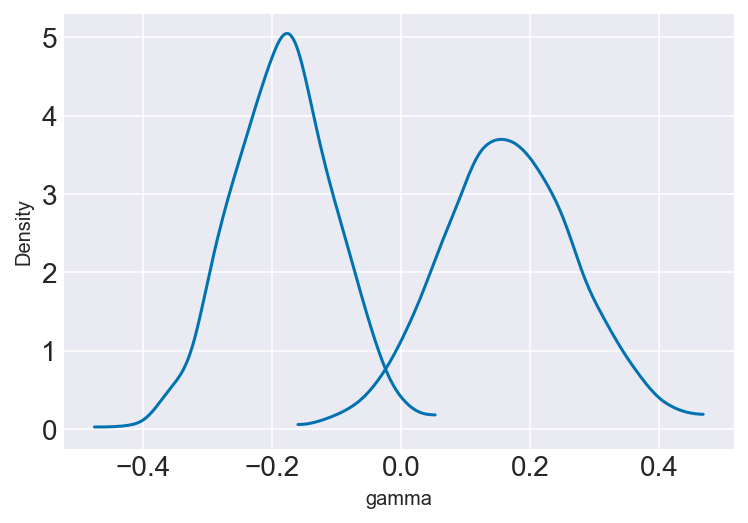

In [28]:
_, ax = plt.subplots()
ax.set_xlabel('gamma')
ax.set_ylabel('Density')
ax.set_ylim(top=5.25)
pm.kdeplot(gamma_Africa, ax=ax)
pm.kdeplot(gamma_notAfrica, ax=ax);

#### Code 7.16

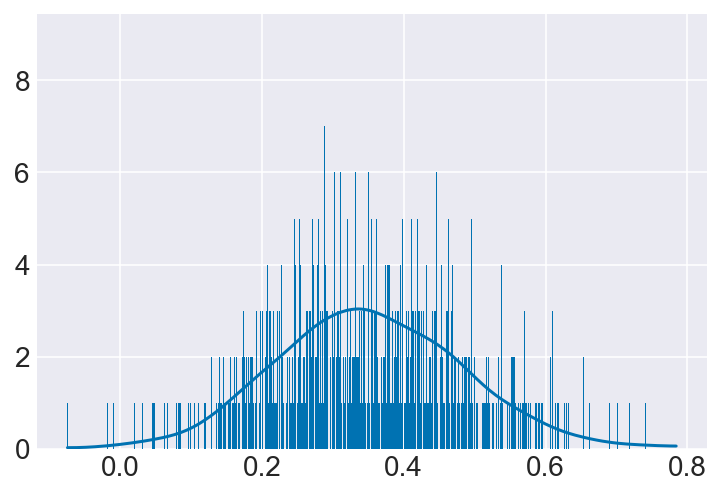

In [29]:
diff = gamma_Africa - gamma_notAfrica
# First let's plot a histogram and a kernel densitiy estimate.
pm.kdeplot(diff)
plt.hist(diff, bins=len(diff));
# Notice that there are very few values below zero.

Hence the probability to have a negative slope association ruggedness with log-GDP inside Africa is so small, it might just be zero.

In [30]:
sum(diff < 0) / len(diff)

0.003